In [1]:
from aemulusnu_massfunction.emulator import *
from aemulusnu_massfunction.fisher_utils import *

loading emulator from /home/users/delon/aemulusnu_massfunction/aemulusnu_massfunction/emulator.pkl


In [5]:
fiducial_cosmology

{'10^9 As': 2.1,
 'ns': 0.9649,
 'H0': 67.36,
 'w0': -1,
 'ombh2': 0.02237,
 'omch2': 0.12,
 'nu_mass_ev': 0.06}

In [6]:
fiducial_log10_rel_step_size

{'10^9 As': -2.6,
 'ns': -4,
 'H0': -2.3,
 'w0': -2.3,
 'ombh2': -2.6,
 'omch2': -2.3,
 'nu_mass_ev': -2.3}

In [56]:
fiducial_log10_rel_step_size.keys()

dict_keys(['10^9 As', 'ns', 'H0', 'w0', 'ombh2', 'omch2', 'nu_mass_ev'])

In [18]:
plt.show()
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

plt.rcParams['font.size'] = 11
# import seaborn as sns

In [26]:
import matplotlib as mpl
import matplotlib.colors as mcolors


In [113]:
labels = {
    '10^9 As': r'10^9A_s',
    'ns': r'n_s',
    'H0': r'H_0',
    'w0': r'w_0',
    'ombh2': r'\Omega_b h^2',
    'omch2': r'\Omega_c h^2',
    'nu_mass_ev': r'\sum m_\nu',
}

In [158]:
from labellines import labelLine, labelLines

[0.  0.4 0.8 1.2 1.6 2. ]


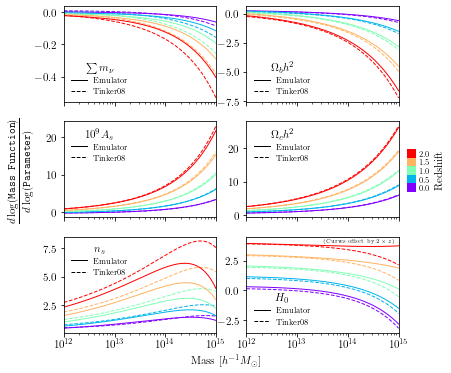

In [219]:
zs = np.linspace(0,2,5)
rainbow = mpl.colormaps['rainbow'].resampled(len(zs))
rainbow_list = [mcolors.rgb2hex(rainbow(i)) for i in range(rainbow.N)]

varied_param = 'nu_mass_ev'


fig, meta_axs = plt.subplots(3,2, figsize=(6,6), sharex=True)

for varied_param,axs in zip(['nu_mass_ev', 'ombh2'  , '10^9 As', 'omch2', 'ns', 'H0', ], meta_axs.flatten()):
    step = np.abs(fiducial_cosmology[varied_param]) * 10**fiducial_log10_rel_step_size[varied_param]


    cosmology_plus = fiducial_cosmology.copy()
    cosmology_plus[varied_param] +=  step
    cosmo_plus = get_ccl_cosmology(tuple(get_cosmo_vals(cosmology_plus)))

    cosmology_minus = fiducial_cosmology.copy()
    cosmology_minus[varied_param] -=  step
    cosmo_minus = get_ccl_cosmology(tuple(get_cosmo_vals(cosmology_minus)))

    M = 10**np.linspace(12, 15, 150)
    h = fiducial_cosmology['H0']/100

    for i, (mf,lbl) in enumerate(zip([tinker08_hmf, emulator ], 
                           [ 'tinker', 'aemulus',])):

        for j,z_curr in enumerate(zs):
            dndm_plus = mf(cosmo_plus, M/h, redshiftToScale(z_curr))
            dndm_minus = mf(cosmo_minus, M/h, redshiftToScale(z_curr))
            dndm_dAs = (dndm_plus- dndm_minus)/(2*step)
            dndm_fid = mf(fiducial_ccl_cosmo,  M/h, redshiftToScale(z_curr))
            sty = '-'
            if(i==0):
#                 print(mf.name)
                sty = '--'
            tmp = 0
            if(varied_param == 'H0'):
                tmp = 2*z_curr
                
            axs.plot(M, fiducial_cosmology[varied_param]*dndm_dAs/dndm_fid+ tmp, 
                     sty, color=rainbow_list[j], lw=1)
            
#     labelLines(axs.get_lines(), zorder=2, fontsize=8)

#     print(labels[varied_param])
    tmp0, tmp1 = (axs.get_ylim())

    axs.plot([-1,0], [-1,0], 'k-', lw=1, label='Emulator')
    axs.plot([-1,0], [-1,0], 'k--', lw=1, label='Tinker08')

    axs.legend(title = r'$%s$'%labels[varied_param], frameon=False, fontsize=8);
    axs.set_ylim(tmp0, tmp1)

    if(varied_param == 'H0'):
        axs.text(.975, .975, s=r'(Curves offset by $2\times z$)',
            transform=axs.transAxes,
            horizontalalignment='right',
            verticalalignment='top',
            c='black',
            fontsize=5)
        axs.set_ylim(tmp0, tmp1+.05*tmp1)

    axs.set_xscale('log')
    axs.set_xlim(1e12, 1e15)
    
    
#         axs.set_ylim(-.15, .15)
    
    
fig.text(0.05, 0.5, r'$$\frac{d\log(\texttt{Mass Function})}{d\log(\texttt{Parameter})}$$'+'\n\n', 
         ha='center', 
         va='center', 
         rotation='vertical',
        fontsize=11)

    
    
fig.text(0.5, 0.075, r'Mass $[h^{-1}M_\odot]$', 
         ha='center', 
         va='top', 
        fontsize=11)


fig.colorbar_ax = fig.add_axes([0.92, 0.45, 0.02, 0.1])  # Adjust the position and size as needed

# Create a colormap from the list of colors
cmap = mpl.colors.ListedColormap(rainbow_list)

# Create a boundary norm with boundaries in the middle of the z values
boundaries = np.linspace(zs.min(), zs.max(), len(zs)+1)
norm = mpl.colors.BoundaryNorm(boundaries, cmap.N, clip=True)
print(boundaries)
# Create a colorbar with the custom cmap and norm
cb = mpl.colorbar.ColorbarBase(fig.colorbar_ax, 
                               cmap=cmap, 
                               norm=norm, 
#                                boundaries=boundaries[:-1], 
                               ticks=[0.2, 0.6,1,1.4,1.8])

# Set the tick labels to the corresponding z values

cb.set_ticklabels([f'{z:.1f}' for z in zs])

cb.outline.set_visible(False)

cb.set_label('Redshift')

cb.ax.tick_params(labelsize=8)
cb.ax.tick_params(size=0)
cb.ax.yaxis.set_tick_params(size=0)  # Hide the ticks
fig.colorbar_ax.tick_params(size=0)
fig.colorbar_ax.tick_params(which='both', size=0)


# Make sure the colorbar is only as tall as the subplots
fig.subplots_adjust(right=0.9)  # Adjust the right parameter to make room for the colorbar

plt.savefig('log_deriv.pdf',bbox_inches='tight')

In [178]:
zs

array([0. , 0.5, 1. , 1.5, 2. ])